In [2]:
import sys
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
sklearn.__version__

'0.22.2.post1'

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m)*3*np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

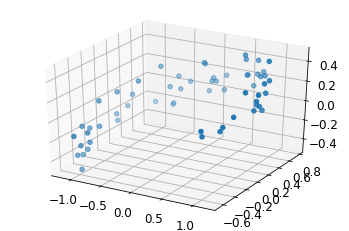

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
# input array : (..., M, N) 
# U : Unitary arrays, {(..., M, M), (..., M, K)}
# s : Vectors with the singular values
# vh : Unitary arrays, {(..., N, N), (..., K, N)}

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [6]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_centered, U.dot(S).dot(Vt))
# Returns True if two arrays are element-wise equal within a tolerance

True

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

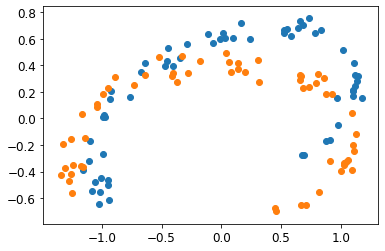

In [8]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(X2D_using_svd[:, 0], X2D_using_svd[:, 1])

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [10]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [11]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [12]:
np.allclose(X2D, -X2D_using_svd)

True

In [13]:
X3D_inv = pca.inverse_transform(X2D)

In [14]:
np.allclose(X3D_inv, X)

False

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [18]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [19]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [20]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [21]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [22]:
np.square(s)/np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

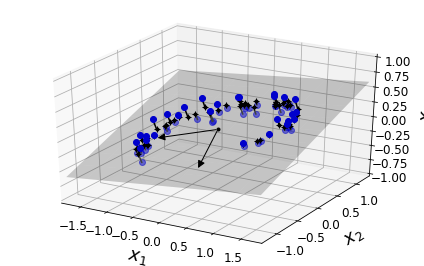

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("dataset_3d_plot")
plt.show()

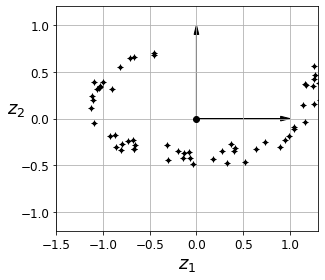

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc="k", ec="k")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc="k", ec="k")
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

In [4]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

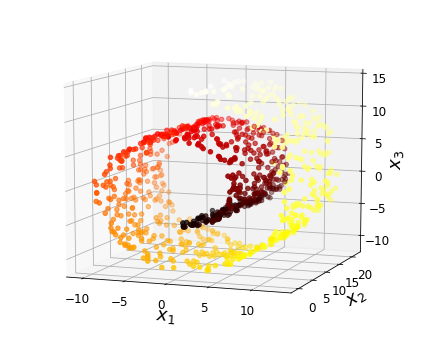

In [28]:
axes=[-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

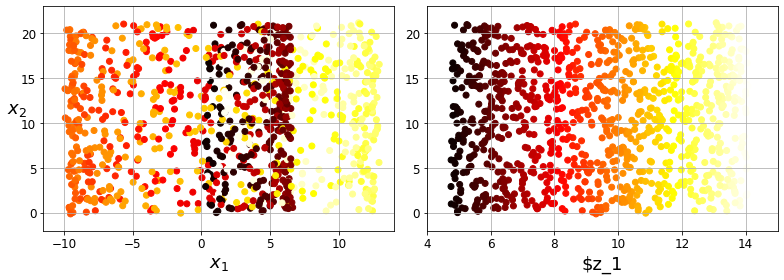

In [29]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

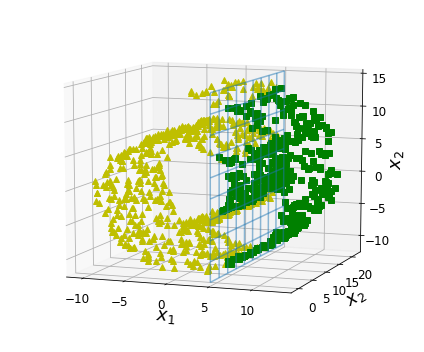

In [30]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection="3d")

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_2$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()


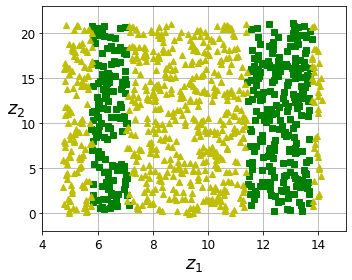

In [31]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

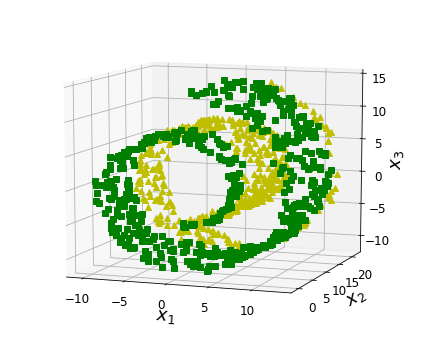

In [32]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

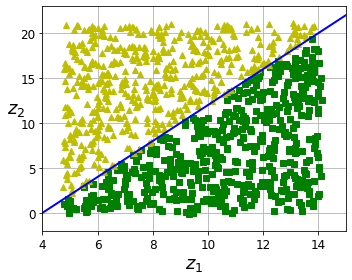

In [33]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

In [34]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [35]:
mnist.target[0]

'5'

In [36]:
mnist.target = mnist.target.astype(np.uint8)
mnist.target[0]

5

In [37]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [39]:
d

154

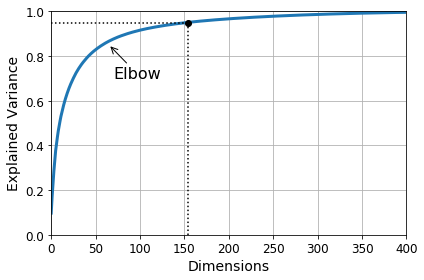

In [40]:

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [41]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [42]:
pca.n_components_

154

In [43]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

In [44]:
def plot_digits(instances, images_per_row=5, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances)-1) // images_per_row + 1
    row_images = []
    
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size*n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

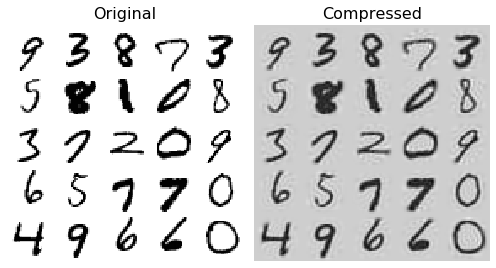

In [45]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [46]:
X_reduced.size/X.size

0.14732142857142858

In [47]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [48]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
x_tmp = np.c_[x1, x2]
print(x_tmp)

x3 = np.array([7,8,9])
print(np.c_[x_tmp, x3])

[[1 4]
 [2 5]
 [3 6]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]


In [49]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

x_tmp = []
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    x_tmp.append(inc_pca.explained_variance_ratio_[:5])
#     print(inc_pca.explained_variance_ratio_[:5])

x_tmp2 = np.c_[x_tmp]

In [50]:
X_reduced = inc_pca.transform(X_train)

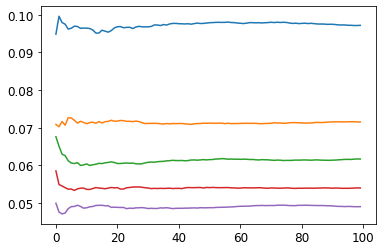

In [51]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(x_tmp2.T[i])


In [52]:
import time

for n_components in (2, 10, 154):
    print("n_components=", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=5000)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")
    
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print(f" {pca.__class__.__name__}: {t2-t1:1f} sec")

n_components= 2
 PCA: 1.341915 sec
 IncrementalPCA: 8.321929 sec
 PCA: 1.083235 sec
n_components= 10
 PCA: 1.649639 sec
 IncrementalPCA: 8.132944 sec
 PCA: 1.429212 sec
n_components= 154
 PCA: 5.855807 sec
 IncrementalPCA: 9.608877 sec
 PCA: 5.738211 sec


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

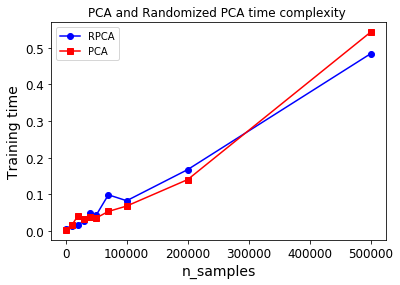

In [53]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

fig, ax = plt.subplots()    
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

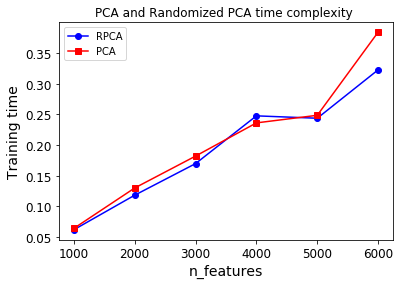

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

fig, ax = plt.subplots()    
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

In [65]:
from sklearn.decomposition import PCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [9]:
from sklearn.decomposition import KernelPCA

In [30]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

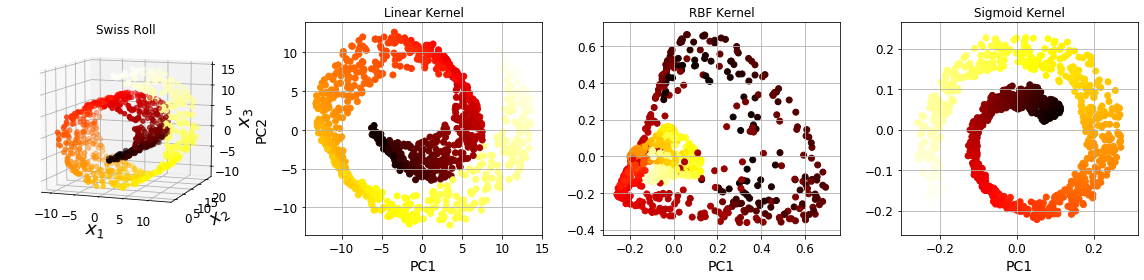

In [33]:
fig = plt.figure(figsize=(16, 4))


axes[0] = fig.add_subplot(141, projection='3d')
axes[0].scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.hot)
axes[0].view_init(10, -70)
axes[0].set_xlabel("$x_1$", fontsize=18)
axes[0].set_ylabel("$x_2$", fontsize=18)
axes[0].set_zlabel("$x_3$", fontsize=18)
axes[0].set_xlim(-11.5, 14)
axes[0].set_ylim(-2, 23)
axes[0].set_zlim(-12, 15)
axes[0].set_title("Swiss Roll")

axes[1] = fig.add_subplot(142)
axes[1].scatter(lin_pca.fit_transform(X)[:,0], lin_pca.fit_transform(X)[:,1], c=t, cmap=plt.cm.hot)
axes[1].set_title("Linear Kernel")
axes[1].grid(True)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

axes[2] = fig.add_subplot(143)
axes[2].scatter(rbf_pca.fit_transform(X)[:,0], rbf_pca.fit_transform(X)[:,1], c=t, cmap=plt.cm.hot)
axes[2].set_title("RBF Kernel")
axes[2].grid(True)
axes[2].set_xlabel("PC1")

axes[2] = fig.add_subplot(144)
axes[2].scatter(sig_pca.fit_transform(X)[:,0], sig_pca.fit_transform(X)[:,1], c=t, cmap=plt.cm.hot)
axes[2].set_title("Sigmoid Kernel")
axes[2].grid(True)
axes[2].set_xlabel("PC1")

plt.tight_layout()
plt.show()



In [56]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

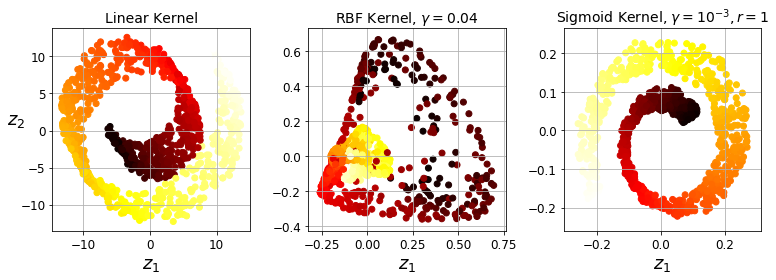

In [32]:
y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear Kernel"), \
                            (132, rbf_pca, "RBF Kernel, $\gamma=0.04$"), \
                            (133, sig_pca, "Sigmoid Kernel, $\gamma=10^{-3}, r=1$")
                           ):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
save_fig("kernel_pca_plt")
plt.show()
    

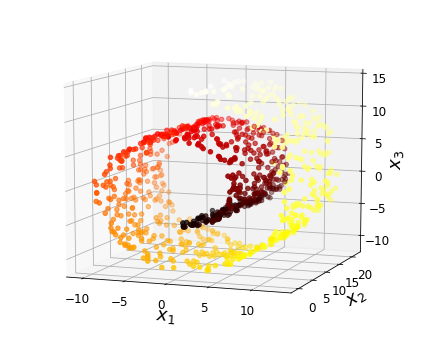

In [28]:
axes=[-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error

### Kernel PCA (1) RBF

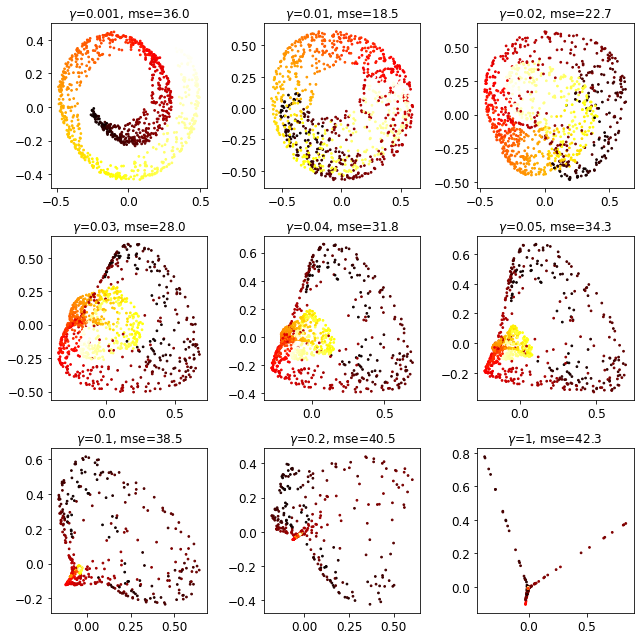

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
ax = axes.ravel()
gammas = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 1]

for axi, gamma in zip(ax, gammas):
    pca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma, fit_inverse_transform=True)
    X_reduced = pca.fit_transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    mse = mean_squared_error(X, X_preimage)
    
    axi.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, s=3, cmap=plt.cm.hot)
    axi.set_title(f"$\gamma$={gamma}, mse={mse:1.1f}")

fig.tight_layout()
save_fig("kernelpca_rbf_plt")
    

### Kernel PCA (2) Poly

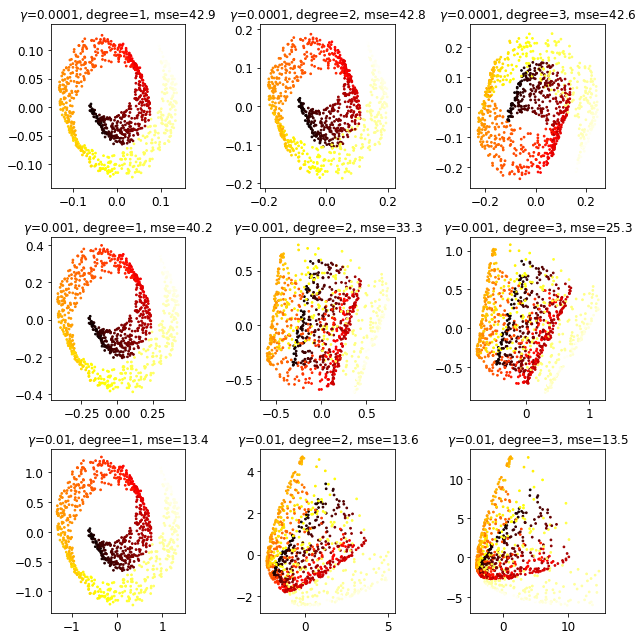

In [77]:
from itertools import product

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
ax = axes.ravel()

gammas = [0.0001, 0.001, 0.01]
degrees = [1, 2, 3]
params = list(product(gammas, degrees))

for axi, param in zip(ax, params):
    gamma, degree = param
    pca = KernelPCA(n_components=2, kernel="poly", gamma=gamma, degree=degree, fit_inverse_transform=True)
    X_reduced = pca.fit_transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    mse = mean_squared_error(X, X_preimage)
    
    axi.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, s=3, cmap=plt.cm.hot)
    axi.set_title(f"$\gamma$={gamma}, degree={degree}, mse={mse:1.1f}")

fig.tight_layout()
save_fig("kernelpca_poly_plt")
    

### Kernel PCA (3) sigmoid

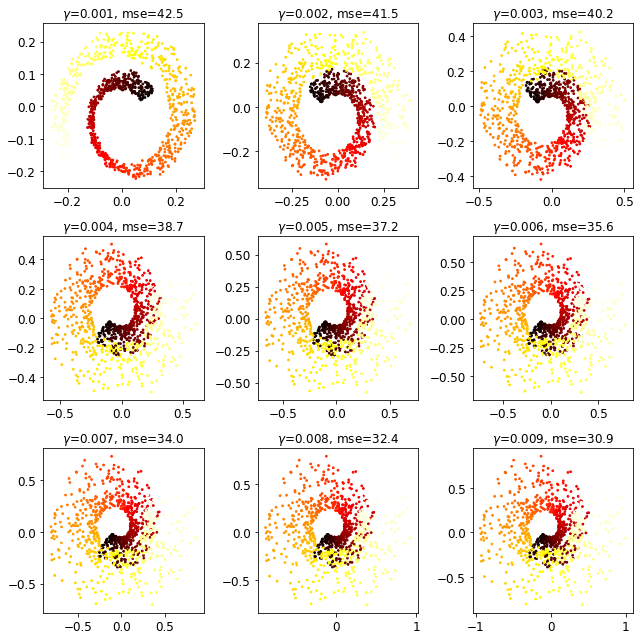

In [86]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(9, 9))
ax = axes.ravel()
gammas = list(np.arange(0.001, 0.01, 0.001))

for axi, gamma in zip(ax, gammas):
    pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=gamma, fit_inverse_transform=True)
    X_reduced = pca.fit_transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    mse = mean_squared_error(X, X_preimage)
    
    axi.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, s=3, cmap=plt.cm.hot)
    axi.set_title(f"$\gamma$={gamma:1.3f}, mse={mse:1.1f}")

fig.tight_layout()
save_fig("kernelpca_sigmoid_plt")
    

### Kernel PCA (4) cosine

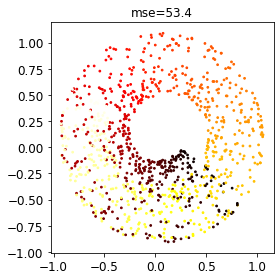

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))

pca = KernelPCA(n_components=2, kernel="cosine", fit_inverse_transform=True)
X_reduced = pca.fit_transform(X)
X_preimage = pca.inverse_transform(X_reduced)
mse = mean_squared_error(X, X_preimage)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, s=3, cmap=plt.cm.hot)
ax.set_title(f"mse={mse:1.1f}")

fig.tight_layout()
save_fig("kernelpca_cosine_plt")
    

In [91]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

X_reduced = lle.fit_transform(X)

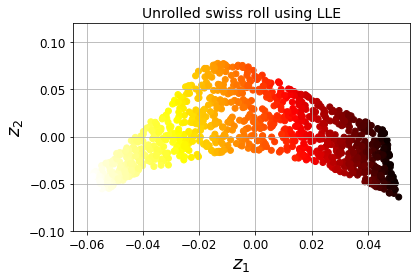

In [92]:

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

### MDS: multidimensional scaling

In [38]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [39]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [88]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [90]:
X[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [93]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [92]:
X[:10]

array([[ -3.29677117,   4.26198454,   7.69787682],
       [  5.95972743,  11.45784273,  12.72625276],
       [  6.66051523,  18.15820401,  -9.84713337],
       [ -6.11824123,  15.48364843,  -8.30589399],
       [  6.33443886,  16.41063456,  -0.4913301 ],
       [  5.990719  ,  13.8351258 ,  -0.59619865],
       [  3.03622034,  14.60337209,  -4.51381014],
       [ 12.20975398,  18.01796271,   3.66237588],
       [ -6.01560606,   5.040249  ,  -8.41286795],
       [  4.1818562 ,  10.29506167, -10.68115121]])

In [94]:
t[:10]

array([ 8.24234644, 13.67266022, 11.61126935, 10.35461227,  6.18283002,
        6.1826027 ,  5.25981413, 12.87590683, 10.37776449, 11.38581581])

In [79]:
t = t.reshape(-1, 1)
t

array([[ 8.24234644],
       [13.67266022],
       [11.61126935],
       [10.35461227],
       [ 6.18283002],
       [ 6.1826027 ],
       [ 5.25981413],
       [12.87590683],
       [10.37776449],
       [11.38581581],
       [ 4.90639327],
       [13.85357398],
       [12.55797604],
       [ 6.71363795],
       [ 6.42604892],
       [ 6.44093576],
       [ 7.57980457],
       [ 9.65810183],
       [ 8.78337487],
       [ 7.45715896],
       [10.47896666],
       [ 6.02708764],
       [ 7.46578743],
       [ 8.16526801],
       [ 9.01074732],
       [12.11249808],
       [ 6.59427004],
       [ 9.55893438],
       [10.29576475],
       [ 5.15017381],
       [10.43836431],
       [ 6.31954098],
       [ 5.3254858 ],
       [13.65542448],
       [13.81325648],
       [12.33135449],
       [ 7.58330612],
       [ 5.63292697],
       [11.16113333],
       [ 8.8607285 ],
       [ 5.86257225],
       [ 9.37932141],
       [ 5.03649316],
       [13.28253187],
       [ 7.15133285],
       [10

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
# X_mnist = mnist["data"]
# y_mnist = mnist["target"]
# lda.fit(X_mnist, y_mnist)
# X_reduced_lda=lda.fit(X[:10], t[:10]).transform(X)
X_reduced_lda = lda.fit_transform(X[:10], y[:10])

/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3, 1 - 1) = 0 components.
  ChangedBehaviorWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:399: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]


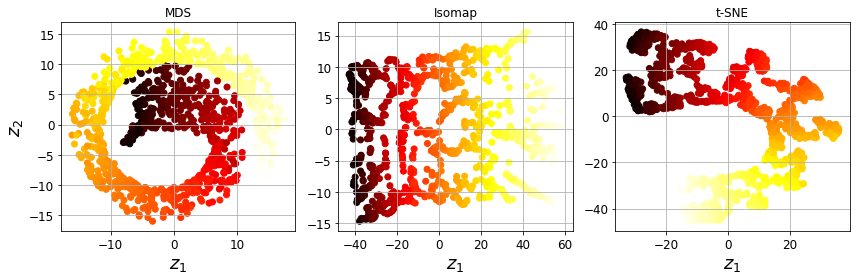

In [101]:
titles = ["MDS", "Isomap", "t-SNE"]
pcas = [X_reduced_mds, X_reduced_isomap, X_reduced_tsne]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax = axes.ravel()

for axi, title, pca in zip(ax, titles, pcas):
    axi.set_title(title)
    if title != "LDA":
        axi.scatter(pca[:,0], pca[:,1], c=t, cmap=plt.cm.hot)
    else:
        axi.scatter(pca[:,0], pca[:,1], c=list(range(len(pca[:,0]))), cmap=plt.cm.viridis, s=3, alpha=0.5)
    axi.set_xlabel("$z_1$", fontsize=18)
    if title == "MDS":
        axi.set_ylabel("$z_2$", fontsize=18)
    axi.grid(True)
    
save_fig("other_dim_reduction_plot")    
plt.show()

In [109]:
np.arange(0, len(pca[:,0]))

array([    0,     1,     2, ..., 69997, 69998, 69999])

In [115]:
len(t)

1000

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [4]:
from sklearn.model_selection import train_test_split

mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
X_train = mnist["data"][:60000]
y_train = mnist["data"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["data"][60000:]

In [6]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]


In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [8]:
y

array([7, 3, 8, ..., 9, 8, 1], dtype=uint8)

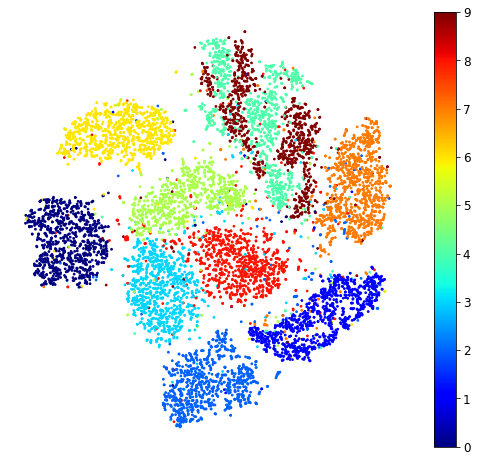

In [15]:
fig, ax = plt.subplots(figsize=(9,8))
im = ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap='jet', s=3)
plt.axis("off")
plt.colorbar(im)
plt.show()

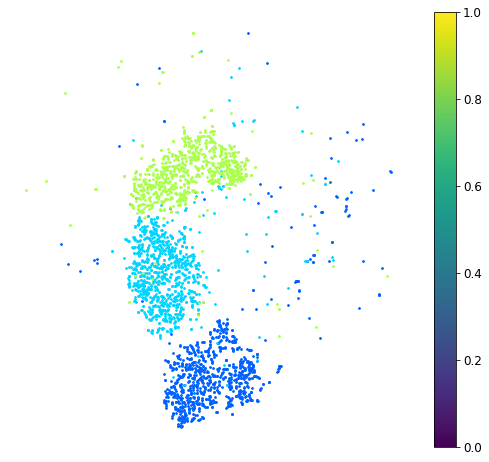

In [18]:
fig, ax = plt.subplots(figsize=(9,8))

cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    im = ax.scatter(X_reduced[y==digit,0], X_reduced[y==digit,1], c=[cmap(digit / 9)], cmap=cmap, s=3)
plt.axis("off")
plt.colorbar(im)
plt.show()

In [23]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

2
3
5


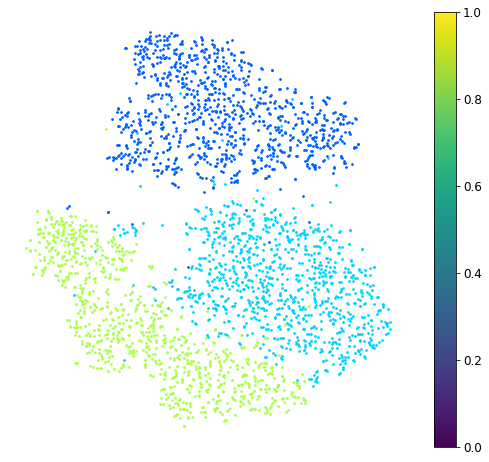

In [27]:
fig, ax = plt.subplots(figsize=(9,8))

cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    print(digit)
    im = ax.scatter(X_subset_reduced[y_subset==digit,0], X_subset_reduced[y_subset==digit,1], c=[cmap(digit / 9)], cmap=cmap, s=3)
plt.axis("off")
plt.colorbar(im)
plt.show()

In [42]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13,10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap=mpl.cm.get_cmap("jet")
    digits=np.unique(y)
    
    for digit in digits:
        plt.scatter(X_normalized[y==digit, 0], X_normalized[y==digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:            
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index]/9), fontdict={"weight":"bold", "size":16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)
        

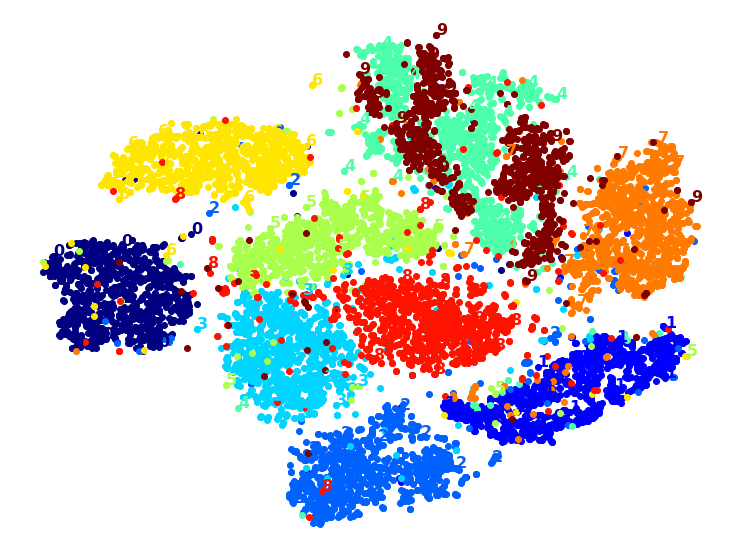

In [43]:
plot_digits(X_reduced, y)

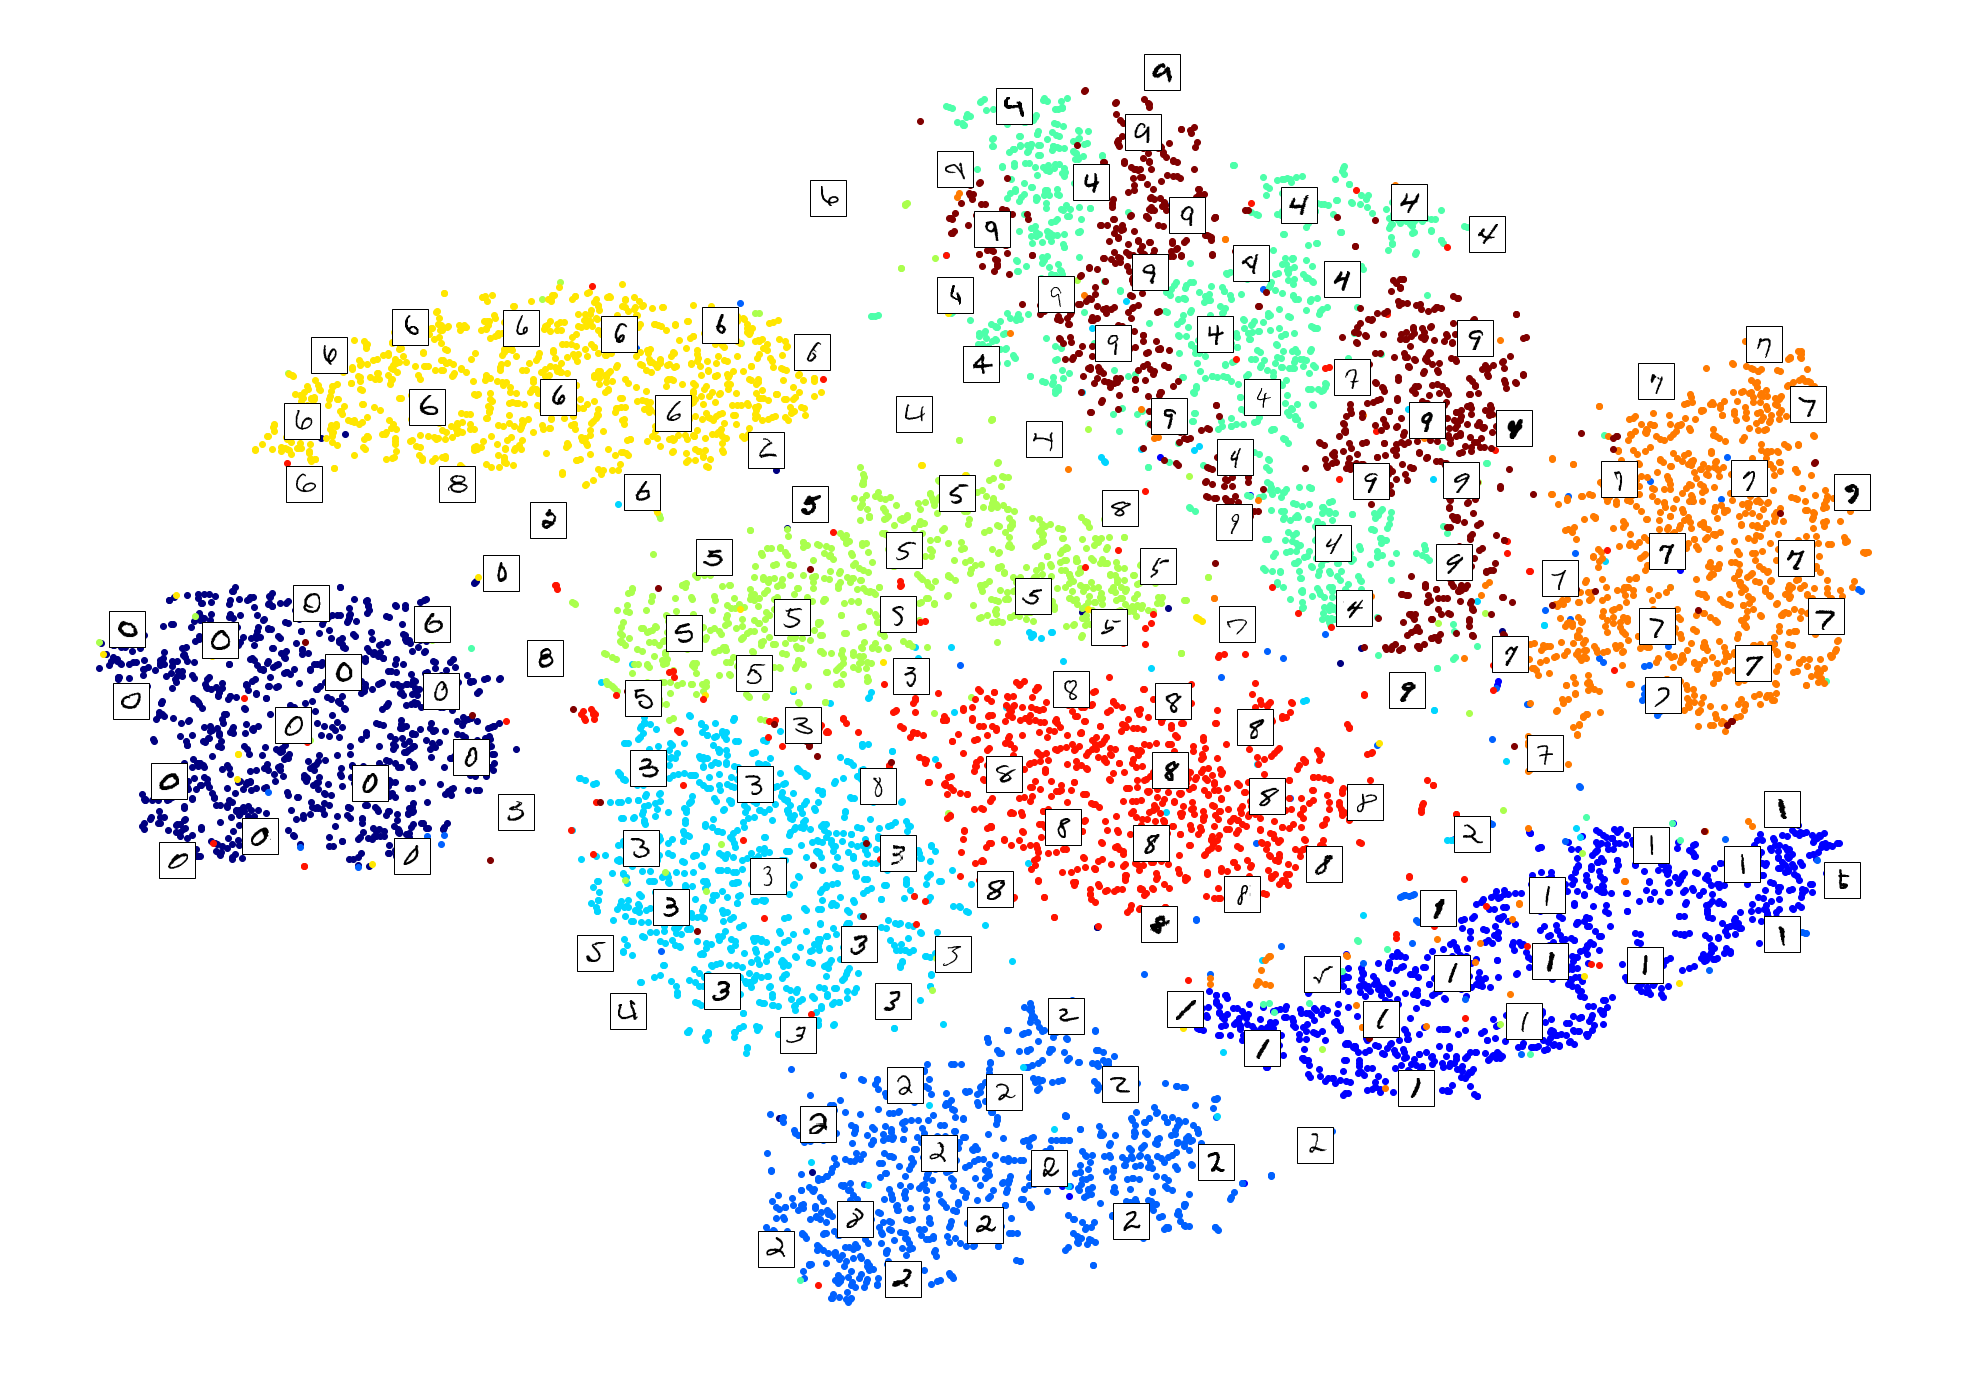

In [44]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

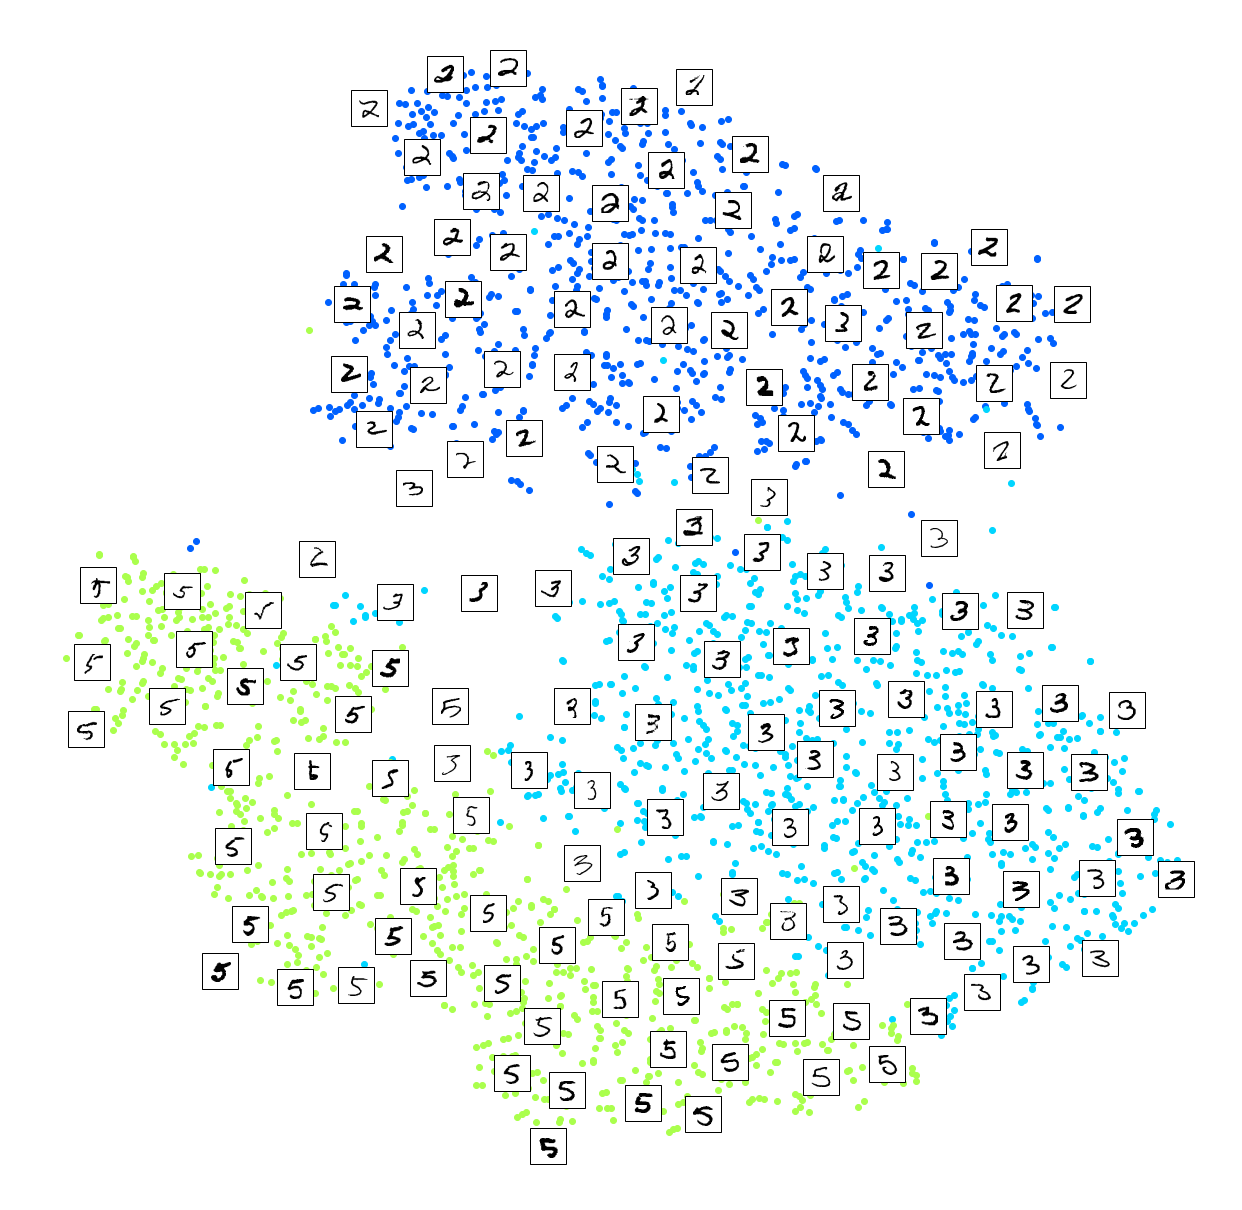

In [45]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))


0.18033123016357422


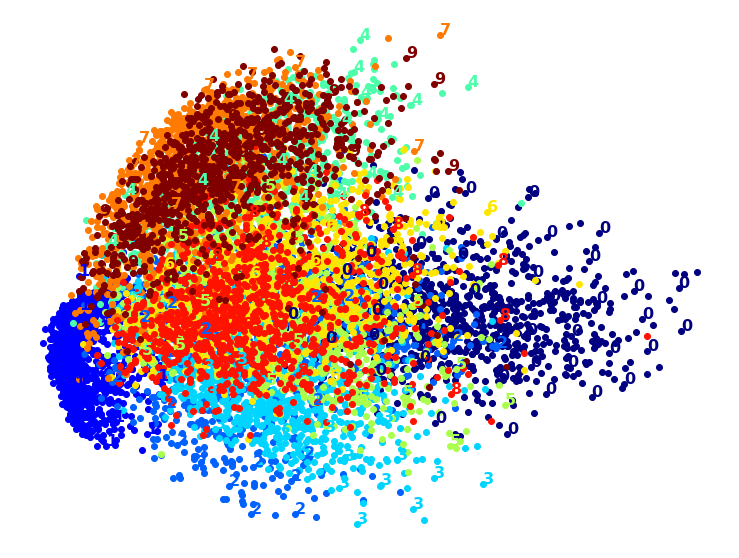

In [46]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print(t1-t0)

plot_digits(X_pca_reduced, y)
plt.show()

169.65809273719788


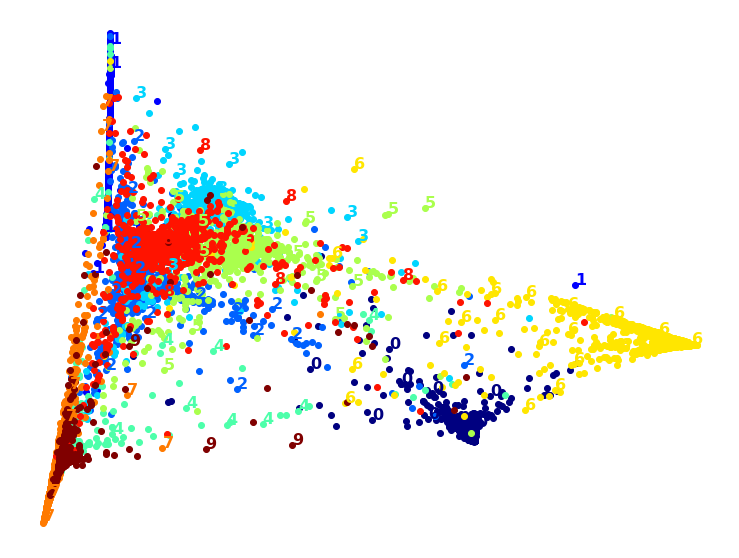

In [47]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print(t1-t0)

plot_digits(X_lle_reduced, y)
plt.show()

51.38472294807434


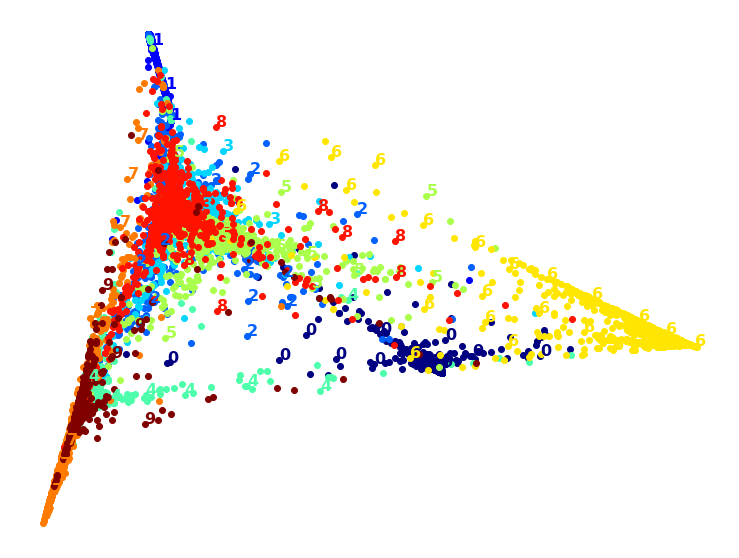

In [48]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()

print(t1 - t0)

plot_digits(X_pca_lle_reduced, y)

101.96208572387695


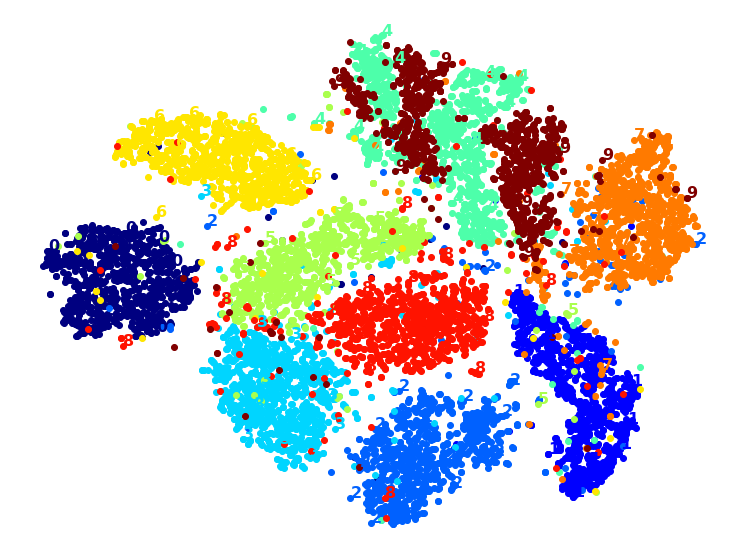

In [49]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()

print(t1 - t0)

plot_digits(X_pca_tsne_reduced, y)
plt.show()